In [1]:
import numpy as np
import random
import math
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
%matplotlib inline

from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
def drop_outlier(array,count,bins):
    index = []
    range_ = np.arange(1,count,bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)

Cycled at constant current of 1°C

In [3]:
Battary_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

dir_path = 'datasets/CALCE/'
Battery = {}
for name in Battary_list:
    print('Load Dataset ' + name + ' ...')
    path = glob.glob(dir_path + name + '/*.xlsx')
    dates = []
    for p in path:
        df = pd.read_excel(p, sheetname=1)
        print('Load ' + str(p) + ' ...')
        dates.append(df['Date_Time'][0])
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]
    
    count = 0
    discharge_capacities = []
    health_indicator = []
    internal_resistance = []
    CCCT = []
    CVCT = []
    for p in path_sorted:
        df = pd.read_excel(p,sheetname=1)
        print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]
            #Charging
            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
            c_v = df_c['Voltage(V)']
            c_c = df_c['Current(A)']
            c_t = df_c['Test_Time(s)']
            #CC or CV
            df_cc = df_lim[df_lim['Step_Index'] == 2]
            df_cv = df_lim[df_lim['Step_Index'] == 4]
            CCCT.append(np.max(df_cc['Test_Time(s)'])-np.min(df_cc['Test_Time(s)']))
            CVCT.append(np.max(df_cv['Test_Time(s)'])-np.min(df_cv['Test_Time(s)']))

            #Discharging
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']

            if(len(list(d_c)) != 0):
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff*d_c/3600 # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1*discharge_capacity[-1])

                dec = np.abs(np.array(d_v) - 3.8)[1:]
                start = np.array(discharge_capacity)[np.argmin(dec)]
                dec = np.abs(np.array(d_v) - 3.4)[1:]
                end = np.array(discharge_capacity)[np.argmin(dec)]
                health_indicator.append(-1 * (end - start))

                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1

    discharge_capacities = np.array(discharge_capacities)
    health_indicator = np.array(health_indicator)
    internal_resistance = np.array(internal_resistance)
    CCCT = np.array(CCCT)
    CVCT = np.array(CVCT)
    
    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                              'capacity':discharge_capacities[idx],
                              'SoH':health_indicator[idx],
                              'resistance':internal_resistance[idx],
                              'CCCT':CCCT[idx],
                              'CVCT':CVCT[idx]})
    Battery[name] = df_result

Load Dataset CS2_35 ...


D:\Program Files (x86)\Anaconda3\lib\site-packages\pandas\util\_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


Load datasets/CALCE/CS2_35\CS2_35_10_15_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_10_22_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_10_29_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_01_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_08_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_23_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_24_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_06_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_13_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_20_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_23_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_10_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_18_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_24_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_28_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_2_10_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_2_4_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_8_17_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_8_18_10.xlsx ...
Load datasets/CALCE/C

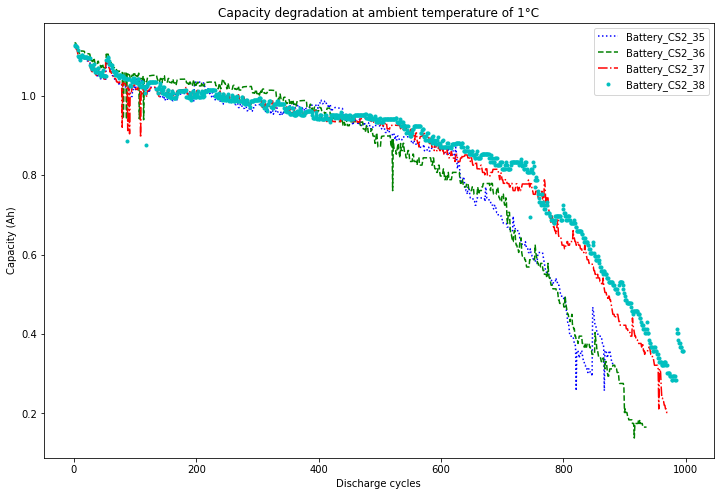

In [4]:
#Rated_Capacity = 1.1
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
for name,color in zip(Battary_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result['cycle'], df_result['capacity'], color, label='Battery_'+name)
#plt.plot([-1,1000],[Rated_Capacity*0.7, Rated_Capacity*0.7], c='black', lw=1, ls='--')  # 临界点直线
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 1°C')
plt.legend()

In [5]:
def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+1:i+1+window_size]

        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)


def split_dataset(data_sequence, train_ratio=0.7, capacity_threshold=0.0):
    if capacity_threshold > 0:
        max_capacity = max(data_sequence)
        capacity = max_capacity * capacity_threshold
        point=[i for i in range(len(data_sequence)) if data_sequence[i] < capacity]
    else:
        point=int(len(data_sequence) * train_ratio)
    train_data, test_data=data_sequence[:point], data_sequence[point:]
    return train_data, test_data


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re


def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse
    
    
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed) # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

三个锂电池的全部数据加一个锂电池的部分数据（train_ratio）为训练集，该锂电池的剩余数据为测试集

In [6]:
def get_train_test(data_dict, name, window_size=8):
    train_data, test_data = split_dataset(data_sequence=data_dict[name]['capacity'], train_ratio=0.5, capacity_threshold=0.0)
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v['capacity'], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
            
    return train_x, train_y, list(train_data), list(test_data)

In [8]:
class Net(nn.Module):
    def __init__(self, feature_size=8, hidden_size=[16, 8]):
        super(Net, self).__init__()
        self.feature_size, self.hidden_size = feature_size, hidden_size
        self.layer0 = nn.Linear(self.feature_size, self.hidden_size[0])
        self.layers = [nn.Sequential(nn.Linear(self.hidden_size[i], self.hidden_size[i+1]), nn.ReLU()) 
                       for i in range(len(self.hidden_size) - 1)]
        self.linear = nn.Linear(self.hidden_size[-1], 1)
 
    def forward(self, x):
        out = self.layer0(x)
        for layer in self.layers:
            out = layer(out)
        out = self.linear(out) 
        return out

In [7]:
window_size = 8
name = Battary_list[0] # 'CS2_35'
train_x, train_y, train_data, test_data = get_train_test(Battery, name, window_size)

In [9]:
# Hyper parameter
EPOCH = 1000
LR = 0.01    # learning rate
feature_size = window_size
hidden_size = [16, 8]
weight_decay = 0.0
seed = 0

Rated_Capacity = 1.1
train_size = len(train_x)
print('sample size: {}'.format(train_size))
mae_list, rmse_list, re_list = [], [], []
for seed in range(10):
    setup_seed(seed)
    model = Net(feature_size=feature_size, hidden_size=hidden_size)
    if torch.cuda.is_available():
        model = model.cuda()

    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    test_x = train_data.copy()
    prediction_list, loss_list, y_ = [], [0], []
    for epoch in range(EPOCH):
        prediction=[]
        X = np.reshape(train_x/Rated_Capacity,(-1, feature_size)).astype(np.float32)
        y = np.reshape(train_y[:,-1]/Rated_Capacity,(-1,1)).astype(np.float32)

        X, y = torch.from_numpy(X), torch.from_numpy(y)
        output= model(X)
        loss = criterion(output, y)
        optimizer.zero_grad()              # clear gradients for this training step
        loss.backward()                    # backpropagation, compute gradients
        optimizer.step()                   # apply gradients

        prediction.append(output[:,0].data.numpy() * Rated_Capacity) #训练集模型预测
        if (epoch + 1)%100 == 0:
            test_x = train_data.copy() #每100次重新预测一次
            point_list = []
            while (len(test_x) - len(train_data)) < len(test_data):
                x = np.reshape(np.array(test_x[-feature_size:])/Rated_Capacity,(-1, feature_size)).astype(np.float32)
                x = torch.from_numpy(x)
                pred = model(x) # 测试集 模型预测#pred shape为(batch_size=1, feature_size=1)
                next_point = pred.data.numpy()[0,0] * Rated_Capacity
                test_x.append(next_point)#测试值加入原来序列用来继续预测下一个点
                point_list.append(next_point)#保存输出序列最后一个点的预测值
            y_.append(point_list)#保存本次预测所有的预测值
            loss_list.append(loss)
            mae, rmse = evaluation(y_test=test_data, y_predict=y_[-1])
            re = relative_error(y_test=test_data, y_predict=y_[-1], threshold=Rated_Capacity*0.7)
            print('epoch:{:<2d} | loss:{:<6.4f} | MAE:{:<6.4f} | RMSE:{:<6.4f} | RE:{:<6.4f}'.format(epoch, loss, mae, rmse, re))
        if (len(loss_list) > 1) and (abs(loss_list[-2] - loss_list[-1]) < 1e-5):
            break

        prediction_list.append(np.reshape(np.array(prediction),(-1)))

    mae, rmse = evaluation(y_test=test_data, y_predict=y_[-1])
    mae_list.append(mae)
    rmse_list.append(rmse)
    re_list.append(re)
    print('------------------------------------------------------------------')
print('RE: mean: {:<6.4f} | std: {:<6.4f}'.format(np.mean(np.array(re_list)), np.std(np.array(re_list))))
print('MAE: mean: {:<6.4f} | std: {:<6.4f}'.format(np.mean(np.array(mae_list)), np.std(np.array(mae_list))))
print('RMSE: mean: {:<6.4f} | std: {:<6.4f}'.format(np.mean(np.array(rmse_list)), np.std(np.array(rmse_list))))

sample size: 3313
epoch:99 | loss:0.0007 | MAE:0.2036 | RMSE:0.2818 | RE:1.0000
epoch:199 | loss:0.0003 | MAE:0.1524 | RMSE:0.2252 | RE:1.0000
epoch:299 | loss:0.0002 | MAE:0.1035 | RMSE:0.1545 | RE:0.3485
epoch:399 | loss:0.0002 | MAE:0.0651 | RMSE:0.0955 | RE:0.1869
epoch:499 | loss:0.0002 | MAE:0.0523 | RMSE:0.0760 | RE:0.1616
------------------------------------------------------------------
epoch:99 | loss:0.0009 | MAE:0.1900 | RMSE:0.2694 | RE:1.0000
epoch:199 | loss:0.0003 | MAE:0.1533 | RMSE:0.2262 | RE:1.0000
epoch:299 | loss:0.0002 | MAE:0.0971 | RMSE:0.1448 | RE:0.3081
epoch:399 | loss:0.0002 | MAE:0.0669 | RMSE:0.0979 | RE:0.2020
------------------------------------------------------------------
epoch:99 | loss:0.0031 | MAE:0.2052 | RMSE:0.2832 | RE:1.0000
epoch:199 | loss:0.0001 | MAE:0.0737 | RMSE:0.1095 | RE:0.1768
epoch:299 | loss:0.0001 | MAE:0.0258 | RMSE:0.0374 | RE:0.0909
epoch:399 | loss:0.0001 | MAE:0.0289 | RMSE:0.0444 | RE:0.1061
--------------------------------

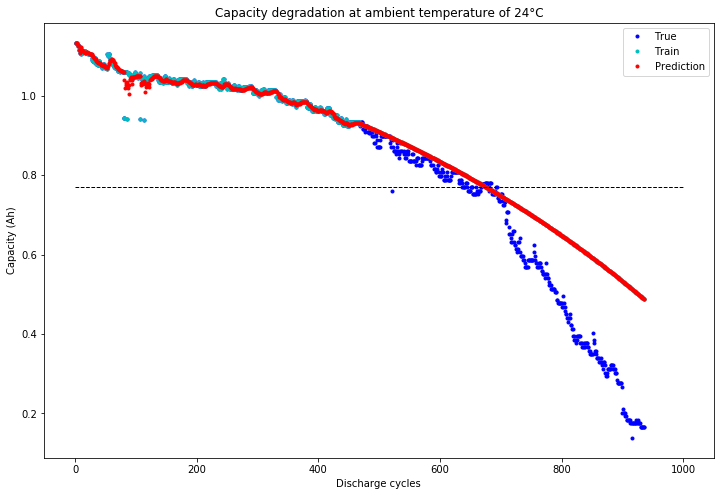

In [16]:
aa = train_data[:window_size].copy() # 第一个输入序列
[aa.append(a) for a in prediction_list[-1][:len(train_data) - window_size]] # 训练集的模型预测值
[aa.append(a) for a in y_[-1]] # 测试集预测结果

battery = Battery[name]
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.plot(battery['cycle'], battery['capacity'], 'b.', label='True')
ax.plot(battery['cycle'], test_x, 'c.', label='Train')
ax.plot(battery['cycle'], aa, 'r.', label='Prediction')
plt.plot([-1,1000],[Rated_Capacity*0.7, Rated_Capacity*0.7], c='black', lw=1, ls='--')  # 临界点直线
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
plt.legend()